# Visium HD Mouse Intestine in SpatialData

This notebook is configured for the local SpatialData archive you downloaded. It extracts the bundled `data.zarr` store into a repo-local cache, opens it with `spatialdata.read_zarr()`, converts the default Visium HD table to `adata`, and runs a standard Scanpy workflow.

Configured archive: `/Users/chrislangseth/Downloads/visium_hd_3.0.0_io_spatialdata_0.7.1.zip`

In [12]:
from pathlib import Path
import os
import zipfile
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import spatialdata as sd

In [13]:
ZIP_PATH = Path(os.environ.get("SPATIALDATA_ZIP_PATH", "/Users/chrislangseth/Downloads/visium_hd_3.0.0_io_spatialdata_0.7.1.zip"))
EXTRACT_ROOT = Path(os.environ.get("SPATIALDATA_EXTRACT_ROOT", "/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_hd_3_0_0_io_spatialdata_0_7_1"))
ZARR_PATH = EXTRACT_ROOT / "data.zarr"

ZIP_PATH, EXTRACT_ROOT, ZARR_PATH

(PosixPath('/Users/chrislangseth/Downloads/visium_hd_3.0.0_io_spatialdata_0.7.1.zip'),
 PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_hd_3_0_0_io_spatialdata_0_7_1'),
 PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_hd_3_0_0_io_spatialdata_0_7_1/data.zarr'))

In [14]:
if not ZIP_PATH.exists():
    raise FileNotFoundError(f"Archive not found: {ZIP_PATH}")

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)

if not ZARR_PATH.exists():
    with zipfile.ZipFile(ZIP_PATH) as zf:
        members = [name for name in zf.namelist() if name.startswith("data.zarr/")]
        if not members:
            raise ValueError(f"Archive does not contain data.zarr/: {ZIP_PATH}")
        zf.extractall(EXTRACT_ROOT, members=members)
        print(f"Extracted {len(members)} members to {EXTRACT_ROOT}")
else:
    print(f"Using existing extracted store: {ZARR_PATH}")

sdata = sd.read_zarr(ZARR_PATH)

for table in sdata.tables.values():
    table.var_names_make_unique()

sdata

Extracted 13089 members to /Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_hd_3_0_0_io_spatialdata_0_7_1


SpatialData object, with associated Zarr store: /Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_hd_3_0_0_io_spatialdata_0_7_1/data.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 3000, 3198)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (547

In [15]:
summary = {
    "images": list(sdata.images),
    "labels": list(sdata.labels),
    "points": list(sdata.points),
    "shapes": list(sdata.shapes),
    "tables": list(sdata.tables),
}

pprint(summary)

{'images': ['Visium_HD_Mouse_Small_Intestine_cytassist_image',
            'Visium_HD_Mouse_Small_Intestine_full_image',
            'Visium_HD_Mouse_Small_Intestine_hires_image',
            'Visium_HD_Mouse_Small_Intestine_lowres_image'],
 'labels': [],
 'points': [],
 'shapes': ['Visium_HD_Mouse_Small_Intestine_square_002um',
            'Visium_HD_Mouse_Small_Intestine_square_008um',
            'Visium_HD_Mouse_Small_Intestine_square_016um'],
 'tables': ['square_002um', 'square_008um', 'square_016um']}


In [16]:
pd.DataFrame(
    [
        {
            "table": name,
            "n_obs": table.n_obs,
            "n_vars": table.n_vars,
            "obs_columns": ", ".join(map(str, table.obs.columns[:12])),
            "var_columns": ", ".join(map(str, table.var.columns[:12])),
            "obsm_keys": ", ".join(map(str, table.obsm_keys())),
        }
        for name, table in sdata.tables.items()
    ]
)

/var/folders/5b/5bpdw2nj10d6gxym7gcl01hh0000gp/T/ipykernel_12892/3778555773.py:9: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  "obsm_keys": ", ".join(map(str, table.obsm_keys())),


table    n_obs  n_vars  \
0  square_002um  5479660   19059   
1  square_008um   351817   19059   
2  square_016um    91033   19059   

                                         obs_columns  \
0  in_tissue, array_row, array_col, location_id, ...   
1  in_tissue, array_row, array_col, location_id, ...   
2  in_tissue, array_row, array_col, location_id, ...   

                       var_columns obsm_keys  
0  gene_ids, feature_types, genome   spatial  
1  gene_ids, feature_types, genome   spatial  
2  gene_ids, feature_types, genome   spatial

## Convert To AnnData

Set `SPATIALDATA_TABLE` in the environment if you want a different table. For this Visium HD mouse intestine archive, the default is `square_016um` when available.

In [17]:
PREFERRED_TABLE = os.environ.get("SPATIALDATA_TABLE")

if PREFERRED_TABLE is not None:
    if PREFERRED_TABLE not in sdata.tables:
        raise KeyError(
            f"Requested table {PREFERRED_TABLE!r} not found. Available tables: {list(sdata.tables)}"
        )
    TABLE_NAME = PREFERRED_TABLE
elif "square_016um" in sdata.tables:
    TABLE_NAME = "square_016um"
elif "cell_segmentations" in sdata.tables:
    TABLE_NAME = "cell_segmentations"
elif "table" in sdata.tables:
    TABLE_NAME = "table"
else:
    TABLE_NAME = next(iter(sdata.tables))

adata = sdata.tables[TABLE_NAME].copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()

if "spatial" not in adata.obsm:
    spatial_candidates = [
        ("x", "y"),
        ("X", "Y"),
        ("center_x", "center_y"),
        ("centroid_x", "centroid_y"),
        ("array_col", "array_row"),
        ("pxl_col_in_fullres", "pxl_row_in_fullres"),
    ]
    for x_key, y_key in spatial_candidates:
        if x_key in adata.obs.columns and y_key in adata.obs.columns:
            adata.obsm["spatial"] = adata.obs[[x_key, y_key]].to_numpy()
            break

if "spatial" not in adata.obsm:
    raise ValueError(
        "Could not determine spatial coordinates for `adata`. "
        "Inspect `adata.obs.columns` and `adata.obsm.keys()` to map coordinates explicitly."
    )

adata.uns["spatialdata_source"] = {
    "zip_path": str(ZIP_PATH),
    "zarr_path": str(ZARR_PATH),
    "table_name": TABLE_NAME,
}

print(f"Selected table: {TABLE_NAME}")
print(adata)
print(f"obsm keys: {list(adata.obsm.keys())}")
adata

Selected table: square_016um
AnnData object with n_obs × n_vars = 91033 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'
obsm keys: ['spatial']


AnnData object with n_obs × n_vars = 91033 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'

## Basic Processing

This follows the same regular Scanpy-style processing added to the other SpatialData notebooks.

In [18]:
sample_key_candidates = ["sample_id", "library_id", "sample", "fov_labels", "region"]
existing_sample_key = next((key for key in sample_key_candidates if key in adata.obs.columns), None)

if existing_sample_key is None:
    adata.obs["sample_id"] = TABLE_NAME
else:
    adata.obs["sample_id"] = adata.obs[existing_sample_key].astype(str)

adata.obs["sample_id"] = adata.obs["sample_id"].astype("category")
adata

AnnData object with n_obs × n_vars = 91033 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'

In [19]:
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

qc_cols = [col for col in ["sample_id", "total_counts", "n_genes_by_counts", "pct_counts_mt"] if col in adata.obs.columns]
adata.obs[qc_cols].head()

sample_id  \
s_016um_00144_00175-1  Visium_HD_Mouse_Small_Intestine_square_016um   
s_016um_00145_00029-1  Visium_HD_Mouse_Small_Intestine_square_016um   
s_016um_00165_00109-1  Visium_HD_Mouse_Small_Intestine_square_016um   
s_016um_00297_00147-1  Visium_HD_Mouse_Small_Intestine_square_016um   
s_016um_00287_00091-1  Visium_HD_Mouse_Small_Intestine_square_016um   

                       total_counts  n_genes_by_counts  pct_counts_mt  
s_016um_00144_00175-1         313.0                249       1.597444  
s_016um_00145_00029-1        2819.0               1733       1.489890  
s_016um_00165_00109-1        2615.0               1644       1.567878  
s_016um_00297_00147-1        2860.0               1419       1.573427  
s_016um_00287_00091-1        2854.0               1731       1.296426

In [20]:
summary_cols = [col for col in ["total_counts", "n_genes_by_counts", "pct_counts_mt"] if col in adata.obs.columns]
(
    adata.obs
    .groupby("sample_id", observed=False)[summary_cols]
    .median()
    .sort_index()
)

total_counts  n_genes_by_counts  \
sample_id                                                                       
Visium_HD_Mouse_Small_Intestine_square_016um        1314.0              880.0   

                                              pct_counts_mt  
sample_id                                                    
Visium_HD_Mouse_Small_Intestine_square_016um       1.959278

In [21]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

adata

AnnData object with n_obs × n_vars = 91032 × 19000
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [22]:
n_top_genes = min(2000, adata.n_vars)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="seurat", subset=True)

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.obsm["X_pca"].shape[1]))
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")

adata

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/5b/5bpdw2nj10d6gxym7gcl01hh0000gp/T/ipykernel_12892/3305339532.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")


AnnData object with n_obs × n_vars = 91032 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1.0'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

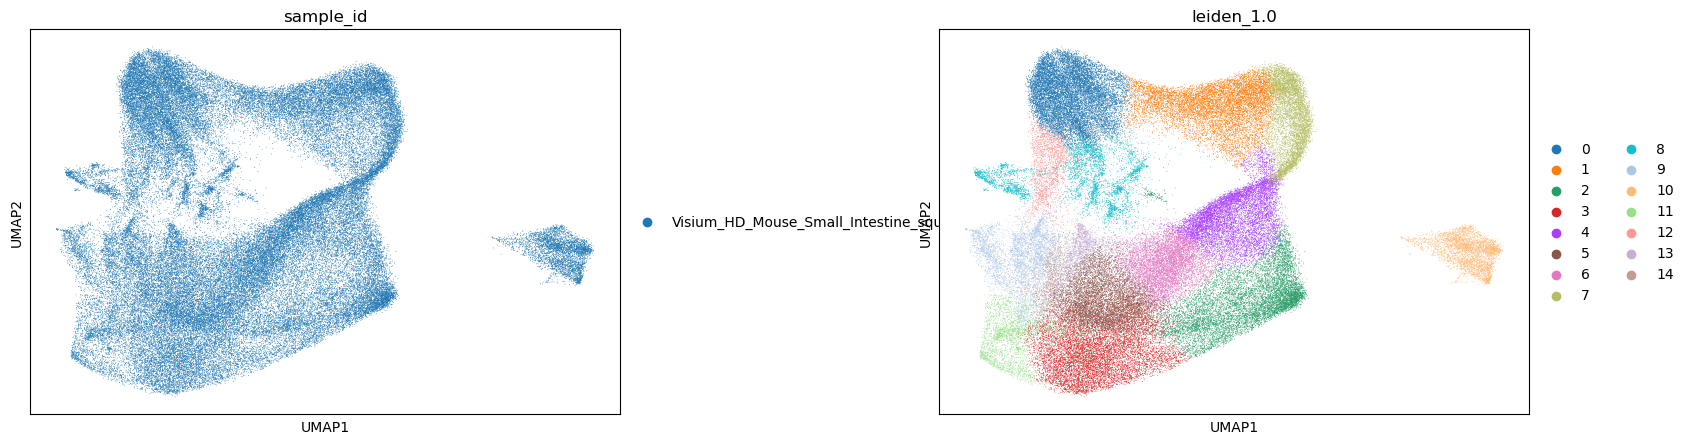

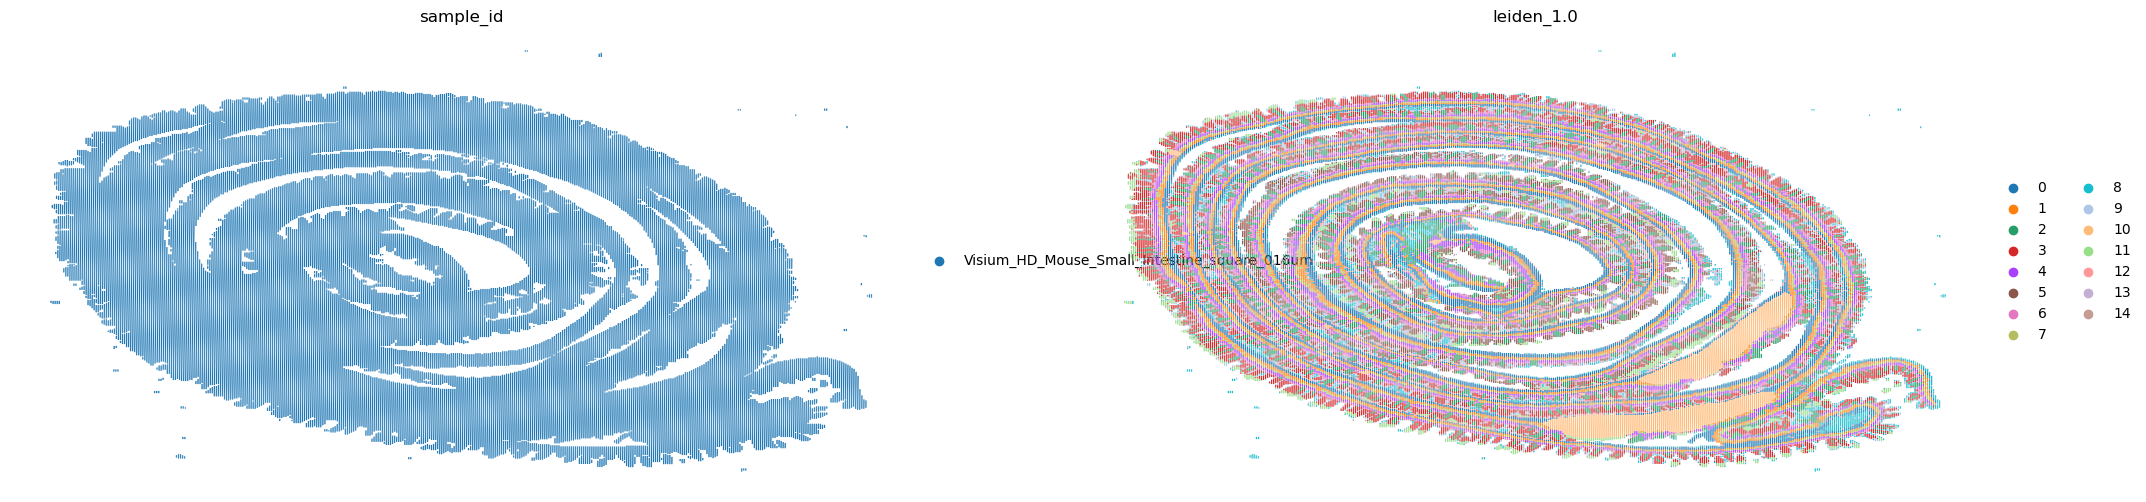

In [23]:
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.umap(adata, color=["sample_id", "leiden_1.0"], wspace=0.4)

with plt.rc_context({"figure.figsize": (12, 6)}):
    sc.pl.embedding(adata, basis="spatial", color=["sample_id", "leiden_1.0"], s=4, frameon=False)

In [24]:
import scvi


In [25]:
adata

AnnData object with n_obs × n_vars = 91032 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1.0'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatialdata_attrs', 'spatialdata_source', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1.0', 'sample_id_colors', 'leiden_1.0_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [27]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(adata)

In [28]:
model.train(early_stopping=True, enable_progress_bar=True, max_epochs = 30 )


/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/scvi/train/_trainrunner.py:86: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `Data

Epoch 30/30: 100%|██████████| 30/30 [07:51<00:00, 15.69s/it, v_num=1, train_loss=242]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [07:51<00:00, 15.72s/it, v_num=1, train_loss=242]


In [29]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)


In [30]:
import squidpy as sq
import cellcharter as cc

In [32]:
sq.gr.spatial_neighbors(adata, library_key='sample_id', coord_type='grid', delaunay=True, percentile=99)


In [33]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')


100%|██████████| 4/4 [00:00<00:00, 16.57it/s]


In [34]:
# GMM components to try
# GMM components to try
gmm_components = [5, 10, 15,20]



In [35]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = adata.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    print(k)
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'CellCharter_{k}'
    adata.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = adata.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')


5
k=5: 5 clusters
10
k=10: 10 clusters
15
k=15: 15 clusters
20
k=20: 20 clusters


## Optional Save

Run the next cell if you want a processed `h5ad` written next to the extracted SpatialData cache.

In [ ]:
adata.obs.sample_id = 'Intenstine'

In [51]:
adata.obs.sample_id = adata.obs.sample_id.astype(str)

In [52]:
OUTPUT_H5AD = EXTRACT_ROOT / f"{Path(ZIP_PATH).stem}_{TABLE_NAME}.processed.h5ad"
adata.write_h5ad(OUTPUT_H5AD)
OUTPUT_H5AD

PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/visium_hd_3_0_0_io_spatialdata_0_7_1/visium_hd_3.0.0_io_spatialdata_0.7.1_square_016um.processed.h5ad')

## Optional Inspection

Use the next cell to inspect the selected table in more detail.

In [ ]:
table_name = TABLE_NAME
table = adata

print(table_name)
print(table)
table.obs.head()

In [38]:
import sys
sys.path.append("/Users/chrislangseth/work/karolinska_institutet/projects/BaloMS/")
from utils import spatial_utils

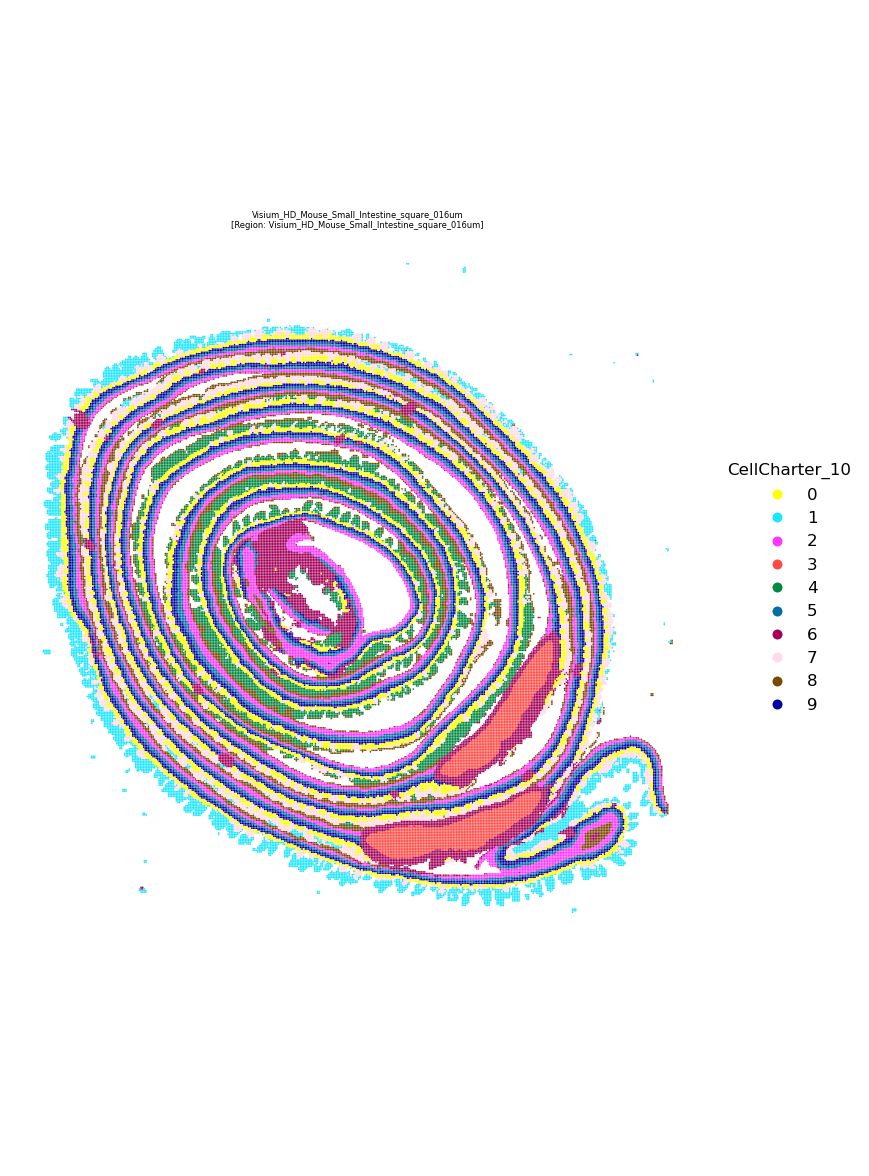

In [41]:
spatial_utils.plot_spatial_compact_fast(
    adata,
    color="CellCharter_10",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)


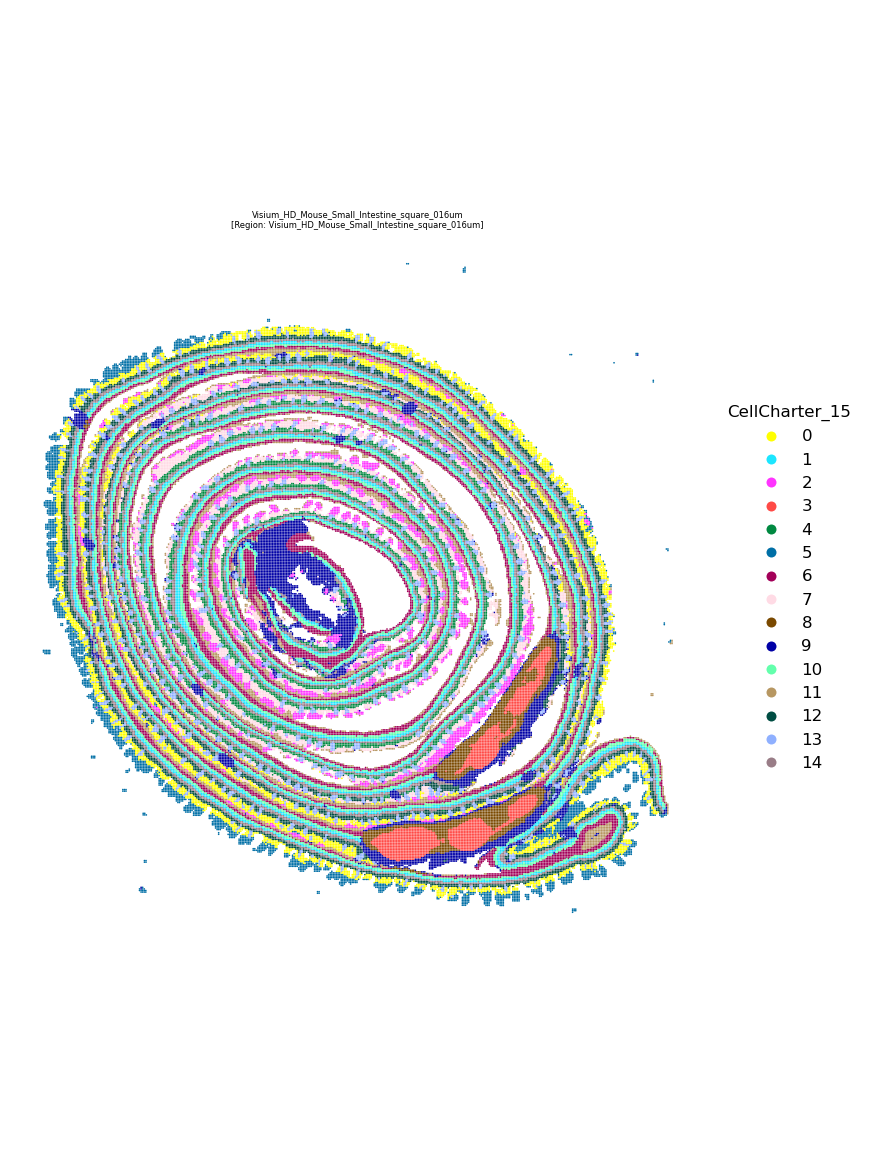

In [42]:
spatial_utils.plot_spatial_compact_fast(
    adata,
    color="CellCharter_15",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)


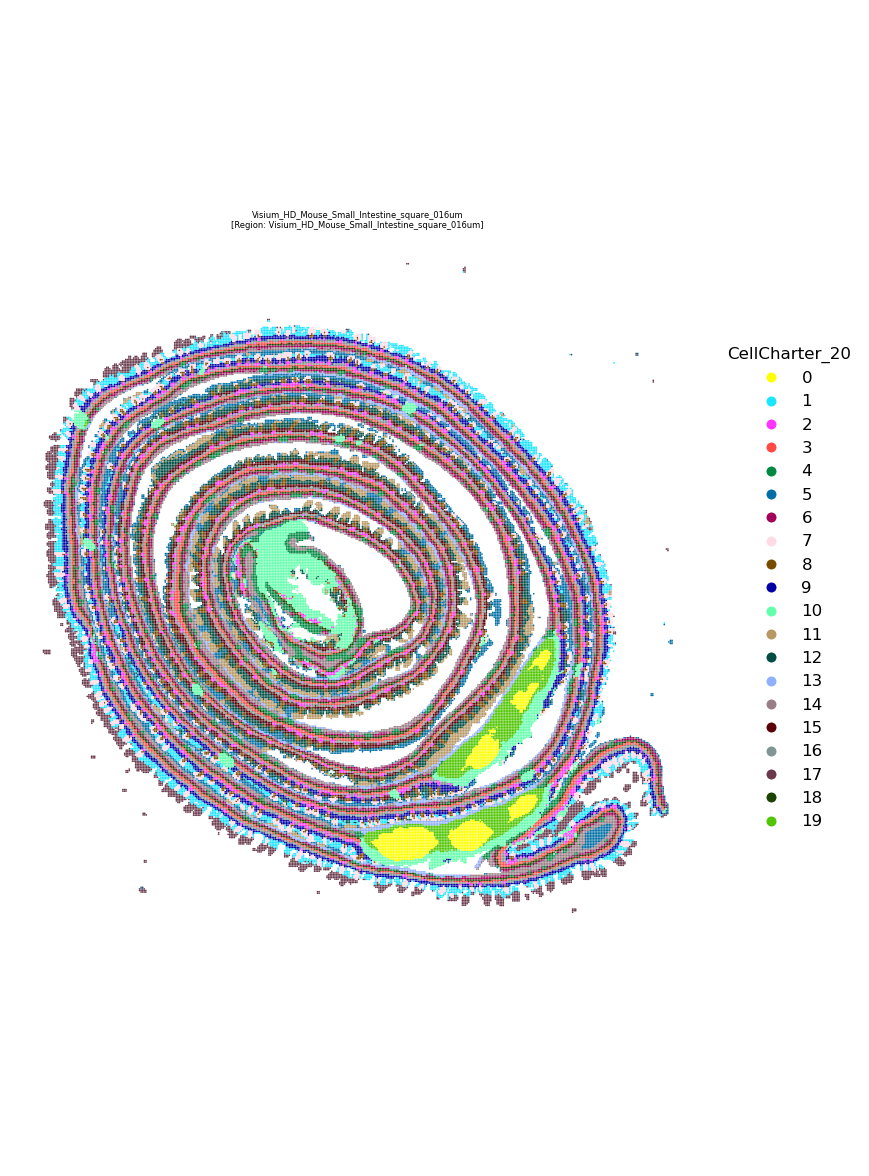

In [43]:
spatial_utils.plot_spatial_compact_fast(
    adata,
    color="CellCharter_20",
    groupby="sample_id",
    spot_size=1,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)
